# **1.0 INTRODUCTION**
The business task is to decide which of the zipcodes is best to invest in.


## **1.1 Import Dependencies**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## **1.2 Data Cleaning**

In [ ]:
df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/zillow_data.csv')

In [ ]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Firstly, we'll drop ***RegionID*** as it is the same as ***RegionName***.<br>
While we're at it, we'll rename our ***RegionName*** to ***zipcode***.

In [ ]:
df = df.drop('RegionID', axis = 1)
df = df.rename({'RegionName': 'zipcode'}, axis = 1)

When we look at the dataframe, we can see we have over 200 columns which represent years. <br>
What we want is a single column that has each of the dates as rows.<br>
Let's alter our dataframe.

In [ ]:
df = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
df.head()

,zipcode,City,State,Metro,CountyName,SizeRank,time,value
0,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0


Now that we've got the structure right, we'll make our ***time*** column a datetime object.

In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901595 entries, 0 to 3901594
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   zipcode     int64         
 1   City        object        
 2   State       object        
 3   Metro       object        
 4   CountyName  object        
 5   SizeRank    int64         
 6   time        datetime64[ns]
 7   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 238.1+ MB


In [ ]:
df.isna().sum()

zipcode            0
City               0
State              0
Metro         276395
CountyName         0
SizeRank           0
time               0
value         156891
dtype: int64

We can see a large amount of na values for both the ***value*** and ***metro*** column. 
The metro column is not so important so it can be dropped. Regarding the na values in the value column, we can fill them using *backfilling*.

In [ ]:
df = df.drop('Metro', axis = 1)

For the backfilling, we'll first of all sort our dataframe by zipcode and dates.

In [ ]:
df = df.sort_values(by = ['zipcode', 'time'])
df = df.backfill()

## **1.3 EDA**
Recall that the task is to use ML to decide on which is the best zipcode to invest in. <br>
We'll begin our EDA by looking at exactly how many zipcodes we have to choose from.

In [ ]:
len(set(df['zipcode']))

14723

We have over ***14.7k*** zipcodes to choose from. <br>
It would be a laborious task to go through each zipcode one by one and determine the best one to invest in. <br>
A better approach would be to narrow our search down. Let's say by ***state*** and view ROI over the past 5 years for each state.

In [ ]:
# We'll take note of our most recent date. 2018-04
df['time'].max()

Timestamp('2018-04-01 00:00:00')

In [ ]:
# We'll firstly create our dataframe that shows the median prices per period for each state
state_df =  df.groupby(['State', 'time']).median().drop(['zipcode', 'SizeRank'], axis = 1)
state_df

value
State time                
AK    1996-04-01  118800.0
      1996-05-01  119450.0
      1996-06-01  120150.0
      1996-07-01  120850.0
      1996-08-01  121300.0
...                    ...
WY    2017-12-01  215000.0
      2018-01-01  216800.0
      2018-02-01  219000.0
      2018-03-01  221000.0
      2018-04-01  221700.0

[13515 rows x 1 columns]

In [ ]:
# We'll then reset the index because we want to easily specify the time period
state_df = state_df.reset_index()

In [ ]:
# We'll specify 5 years prior to our most recent date i.e. 2013 - 04
state_df_2013 = state_df[state_df['time'] == '2013-04']
# We can rename our value column to 2013 price
state_df_2013.rename({'value': '2013_price'}, axis=1, inplace = True)
# We now no longer need the time column
state_df_2013.drop('time', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
state_df_2013.head()

,State,2013_price
204,AK,278900.0
469,AL,121600.0
734,AR,111500.0
999,AZ,168000.0
1264,CA,361300.0


In [ ]:
# We then perform the exact same steps for our most recetn date i.e. 2018-04
state_df_2018 = state_df[state_df['time'] == '2018-04']
state_df_2018.rename({'value': '2018_price'}, axis=1, inplace = True)
state_df_2018.drop('time', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
state_df_2018.head()

,State,2018_price
264,AK,312100.0
529,AL,140500.0
794,AR,132500.0
1059,AZ,238450.0
1324,CA,564700.0


Now, all we need to do is combine both our dataframes into a single one.

In [ ]:
state_df_2013_2018 = state_df_2013.merge(state_df_2018, left_on= 'State', right_on='State')
state_df_2013_2018.head()

,State,2013_price,2018_price
0,AK,278900.0,312100.0
1,AL,121600.0,140500.0
2,AR,111500.0,132500.0
3,AZ,168000.0,238450.0
4,CA,361300.0,564700.0


Whilst we have our prices, we want the ROI i.e. ***percentage change***.

In [ ]:
state_df_2013_2018['5_year_change(%)'] = ((state_df_2013_2018['2018_price'] - state_df_2013_2018['2013_price']) / state_df_2013_2018['2013_price']) * 100

In [ ]:
state_df_2013_2018.head()

,State,2013_price,2018_price,5_year_change(%)
0,AK,278900.0,312100.0,11.903908
1,AL,121600.0,140500.0,15.542763
2,AR,111500.0,132500.0,18.834081
3,AZ,168000.0,238450.0,41.934524
4,CA,361300.0,564700.0,56.296706


Finally, we just sort by State to give us the one with the highest ROI.

In [ ]:
state_df_2013_2018.sort_values('5_year_change(%)', ascending=False)

,State,2013_price,2018_price,5_year_change(%)
33,NV,170000.0,287600.0,69.176471
9,FL,137700.0,226100.0,64.197531
5,CO,225700.0,365800.0,62.073549
7,DC,497250.0,785750.0,58.019105
37,OR,190750.0,298350.0,56.408912
4,CA,361300.0,564700.0,56.296706
47,WA,213600.0,333800.0,56.273408
44,UT,198000.0,291500.0,47.222222
13,ID,141900.0,206850.0,45.771670
22,MI,104600.0,150900.0,44.263862


In our case, we see that ***Nevada*** is the winner. <br><br>
What we'll now do is focus our attention on picking the best zipcode within Nevada. This significantly reduces time taken to do this project. <br><br>
But first, let's make sure to save this dataframe. We can make some visuals using ***tableau*** later on.

In [ ]:
state_df_2013_2018.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/state_df_2013_2018.csv')

Firstly, we'll make a nevada dataframe that includes the median ***value*** and ***ROI***.

In [ ]:
nv_grouped_df = pd.DataFrame(df[df['State'] == 'NV'].groupby('time').median()['value'])
nv_grouped_df['ROI'] = nv_grouped_df['value'].pct_change()
nv_grouped_df = nv_grouped_df.dropna()
nv_grouped_df.head()

,value,ROI
time,,
1996-05-01,144900.0,-0.001378
1996-06-01,144700.0,-0.001380
1996-07-01,144500.0,-0.001382
1996-08-01,144400.0,-0.000692
1996-09-01,144400.0,0.000000


We can then visualise the change in ROI with respect to change in value. 

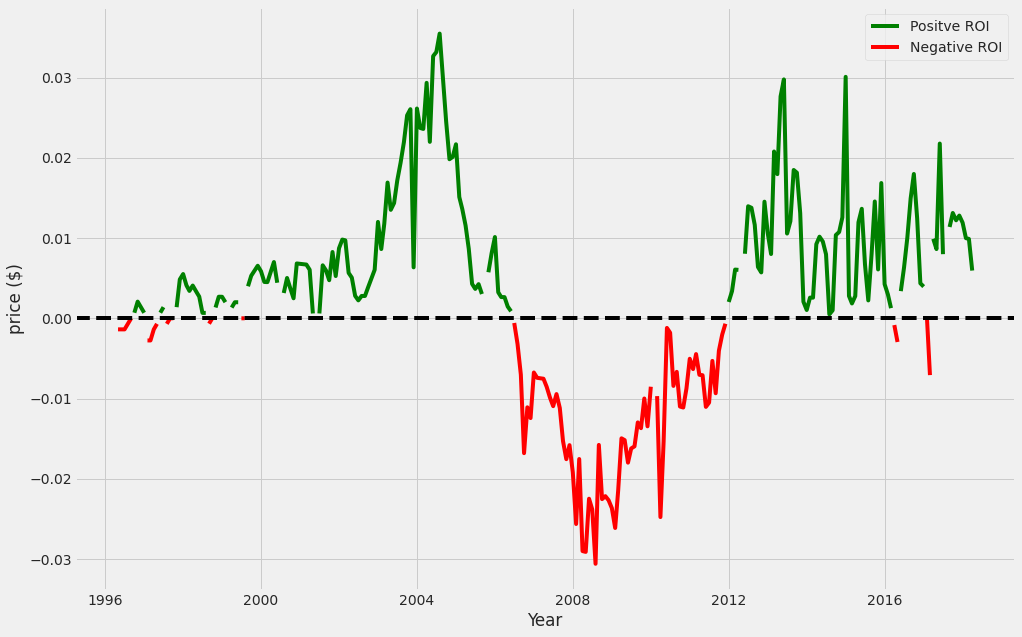

In [ ]:
plt.style.use('fivethirtyeight')
ROI_plot = nv_grouped_df['ROI']
positive_ROI = ROI_plot.copy()
negative_ROI = ROI_plot.copy()

positive_ROI[positive_ROI <= 0 ] = np.nan
negative_ROI[negative_ROI > 0] = np.nan

fig, ax = plt.subplots(figsize = (15, 10))
plt.style.use('fivethirtyeight')
ax.plot(positive_ROI, color = 'green', label = 'Positve ROI')
ax.plot(negative_ROI, color = 'red', label = 'Negative ROI')
plt.axhline(y = 0, linestyle = '--' , color = 'black')
ax.set_ylabel('price ($)')
ax.set_xlabel('Year')
plt.legend();

We can visualise the median change in value of nevada property vs the entire country's since 1996 to now.

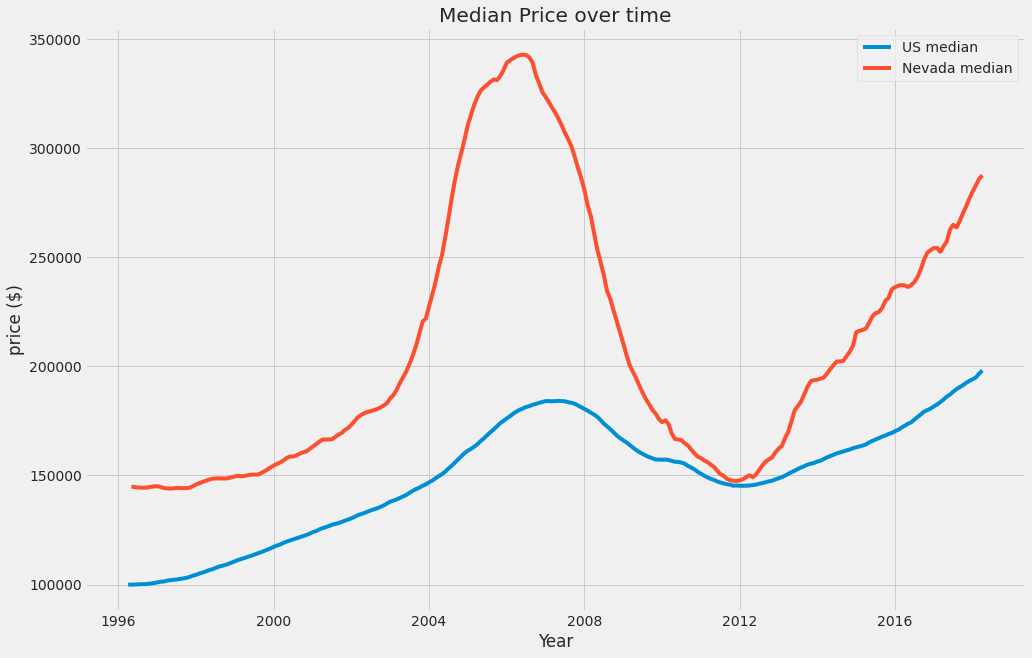

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Median Price over time')
ax.set_ylabel('price ($)')
ax.set_xlabel('Year')
ax.plot(df.groupby('time').median()['value'], label = 'US median')
ax.plot(nv_grouped_df['value'], label = 'Nevada median')
plt.legend()
plt.show();

# **2.0 Feature Engineering**

Firstly, we'll create our Nevada DataFrame.

In [ ]:
df_nv = df[df['State'] == 'NV']

In [ ]:
df_nv.isna().sum()

zipcode       0
City          0
State         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

As the state is constant, we can drop that column.

In [ ]:
df_nv.drop(['State'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We'll perform a similar analysis as we did before by seeing which zipcodes have achieved the highest ROI over the past 5 years.

In [ ]:
df_nv_2013 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2013-04']
df_nv_2013 = df_nv_2013.set_index('time')[['zipcode', 'value']].rename({'value': '2013_price'}, axis = 1)
df_nv_2018 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2018-04']
df_nv_2018 = df_nv_2018.set_index('time')[['zipcode', 'value']].rename({'value': '2018_price'}, axis = 1)
df_nv_2013_2018 = df_nv_2013.merge(df_nv_2018, left_on= 'zipcode', right_on='zipcode')
df_nv_2013_2018['5_year_change(%)'] = ((df_nv_2013_2018['2018_price'] - df_nv_2013_2018['2013_price']) / df_nv_2013_2018['2013_price']) * 100
df_nv_2013_2018 = df_nv_2013_2018.sort_values(by = '5_year_change(%)', ascending = False)

In [ ]:
df_nv_2013_2018

,zipcode,2013_price,2018_price,5_year_change(%)
9,89030,62100.0,151300.0,143.639291
26,89104,90100.0,208500.0,131.409545
30,89110,85900.0,196600.0,128.870780
71,89431,110600.0,250900.0,126.853526
32,89115,79000.0,176000.0,122.784810
...,...,...,...,...
78,89444,211400.0,286000.0,35.288553
12,89034,256800.0,326600.0,27.180685
8,89029,144800.0,181200.0,25.138122
101,89801,234000.0,244200.0,4.358974


In [ ]:
df_nv_2013_2018.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/df_nv_2013_2018.csv')

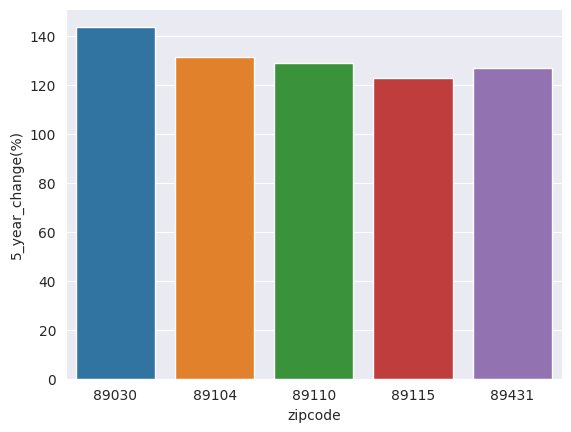

In [ ]:
plt.style.use('default')
sns.set_style('darkgrid')
sns.barplot(data = df_nv_2013_2018.head(), x = 'zipcode', y = '5_year_change(%)');

We can see the breakdown of the top 5 performing zipcodes.

To make our model more accurate, we'll perform some feature engineering. We'll do this mainly by webscraping a series of data: <br>
> ***macro-economic features*** <br>
> ***micro-economic features*** 

We'll create a function to do this for us.

In [ ]:
# We'll create a fucntion to webscrape all the unique zipcode values
def scrape_data(zipcode):

    import json
    import requests
    from bs4 import BeautifulSoup
    import time
    import re
    import time
    import numpy as np

    time.sleep(2)
    zipcode = str(zipcode)

    # Setting up the web scraper
    headers = requests.utils.default_headers()
    headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })

    url = f'https://www.unitedstateszipcodes.org/{zipcode}/'

    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.content, 'html.parser')

    if len(soup.find_all('script')) != 46:
        blank_dict = {'time': np.nan, 'RegionName': zipcode, 
                      'population': np.nan, 'household_income': np.nan, 
                      'population_density': np.nan}
        return blank_dict
    else:
        # We'll firstly retrieve the populations
        zipcode_1 = str(zipcode)
        pop_text = soup.find_all('script')[11].string.strip().replace('\t', '').replace('\n', '')
        pattern = '(?:\[)(.*)(?=];var.c)'
        population_group = json.loads(re.findall(pattern, pop_text)[0])
        population = population_group['values']
        pop_list = [i['y'] for i in population]
        time = [i['x'] for i in population]

        # We'll then retrieve the area of the zipcode in square miles
        land_area = float(soup.find_all('td', class_='text-right')[4].get_text().replace(',', ''))
        
        # Average income per zipcode
        income_text = soup.find_all('script')[-16].string.strip().replace('\t', '').replace('\n', '')
        income_group = json.loads(re.findall(pattern, income_text)[0])
        income = income_group['values']
        income_list = [round(i['y'], 2) for i in income]
        
        # Then we form a dictionary from the scraped data
        zipcode_dictionary = {'time': time, 
                            'population': pop_list, 'land_area': land_area, 
                            'household_income': income_list}

        # We'll now convert the 
        df = pd.DataFrame(zipcode_dictionary)
        
        # Set the time column to datetime and set it as an index
        df['time'] = pd.to_datetime(df['time'], format='%Y')
        df.set_index('time', inplace = True)

        # The scraped data is yearly so we'll need to resample it to make it monthly
        df = df.resample('M').mean()

        # Fill the na values with interpolation
        df = df.interpolate(method = 'polynomial', order = 2)

        # Feature engineer a population density column
        df['population_density'] = df['population'] / df['land_area']
        df.drop('land_area', axis = 1, inplace = True)

        # Turn our values into integers
        df['population'] = df['population'].apply(lambda x: int(x))
        df['household_income'] = df['household_income'].apply(lambda x: int(x))

        df = df.reset_index()
        df['time'] = df['time'].apply(lambda x: str(x)[:-11] + '01')
        df['RegionName'] = zipcode

        return df

Here is an example of what the function will return.

In [ ]:
scrape_data(89102).head()

,time,population,household_income,population_density,RegionName
0,2005-01-01,31083,57348,5799.067164,89102
1,2005-02-01,31115,57348,5805.093658,89102
2,2005-03-01,31179,57307,5816.983757,89102
3,2005-04-01,31268,57227,5833.711066,89102
4,2005-05-01,31390,57103,5856.390741,89102


Now, we'll get a list of each of our dataframes of scraped data.

In [ ]:
scraped_data = [scrape_data(zipcode) for zipcode in list(set(df_nv['zipcode']))]

In our function, we made sure to return an empty dictionary if the zipcode could not be found when attempting to scrape. <br>
Let's see which zipcodes could not be found.

In [ ]:
missing_zipcodes = []
for i in scraped_data:
    if type(i) == dict:
        missing_zipcodes.append(i['RegionName'])

print(missing_zipcodes)
print(f'number of missing zipcodes: {len(missing_zipcodes)}')

['89155', '89411', '89440', '89448', '89449', '89021', '89034']
number of missing zipcodes: 7


Now, we'll make sure to only include those which were not missing.

In [ ]:
scraped_df_list = []
for i in scraped_data:
    if type(i) != dict:
        scraped_df_list.append(i)

We should check the number of rows that each dataframe has. Ideally, they should all be equal.

In [ ]:
pd.Series([len(i) for i in scraped_df_list]).value_counts()

157    95
145     1
dtype: int64

We can see that all but 1 has a length of 157 rows. We can check to see which zipcode is the culprit.

In [ ]:
[len(i) for i in scraped_df_list].index(145)

66

We'll simply remove this from our list of dataframes.

In [ ]:
scraped_df_list.pop(66)

,time,population,household_income,population_density,RegionName
0,2006-01-01,509,49530,3.189423,89508
1,2006-02-01,1605,49656,10.057490,89508
2,2006-03-01,2743,49803,17.188283,89508
3,2006-04-01,3768,49952,23.615653,89508
4,2006-05-01,4750,50114,29.768092,89508
...,...,...,...,...,...
140,2017-09-01,11888,63971,74.491284,89508
141,2017-10-01,11892,64061,74.517457,89508
142,2017-11-01,11893,64124,74.527954,89508
143,2017-12-01,11893,64163,74.523474,89508


In [ ]:
# And double check that we have an equal number of rows for all dataframes
pd.Series([len(i) for i in scraped_df_list]).value_counts()

157    95
dtype: int64

Now we can concatenate all of the dataframes and make sure our ***time*** column is a datetime object as well as rename our ***RegionName*** to ***zipcode***.

In [ ]:
scraped_df = pd.concat(scraped_df_list)
scraped_df['time'] = pd.to_datetime(scraped_df['time'])
scraped_df = scraped_df.rename({'RegionName': 'zipcode'}, axis = 1)
scraped_df.head()

,time,population,household_income,population_density,zipcode
0,2005-01-01,31083,57348,5799.067164,89102
1,2005-02-01,31115,57348,5805.093658,89102
2,2005-03-01,31179,57307,5816.983757,89102
3,2005-04-01,31268,57227,5833.711066,89102
4,2005-05-01,31390,57103,5856.390741,89102


In [ ]:
scraped_df.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/scraped_df.csv')

In [ ]:
scraped_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/scraped_df.csv')
scraped_df['time'] = pd.to_datetime(scraped_df['time'])
scraped_df = scraped_df.set_index('time')

Besides scraping data for each zipcode, we can also utilise country-wide data.<br>
In particular:<br>
> ***CPI*** <br>
> ***Real GDP*** <br>
> ***Inflation Rate*** <br>
> ***Unemployment Rate*** <br> 

In [ ]:
CPI_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/CPIAUCSL.csv')
realGDP_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/GDPC1.csv')
inflation_rate_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/FPCPITOTLZGUSA.csv')
unemployment_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/UNRATE.csv')

We need to do some quick data cleaning.

In [ ]:
from functools import reduce
imported_df = reduce(lambda left,right: pd.merge(left,right,on='DATE'), 
                    [CPI_df, realGDP_df, inflation_rate_df, unemployment_df])

In [ ]:
# rename our columns
imported_df = imported_df.rename(columns={'DATE': 'time',
                                         'CPIAUCSL': 'CPI', 
                                         'GDPC1': 'real_GDP', 
                                         'FPCPITOTLZGUSA': 'inflation', 
                                         'UNRATE': 'unemployment_rate'})

In [ ]:
# round our values
imported_df['CPI'] = imported_df['CPI'].apply(lambda x: round(float(x), 2))
imported_df['real_GDP'] = imported_df['real_GDP'].apply(lambda x: round(x,2))
imported_df['inflation'] = imported_df['inflation'].apply(lambda x: round(x, 2))

In [ ]:
imported_df.head()

,time,CPI,real_GDP,inflation,unemployment_rate
0,1960-01-01,29.59,3262.06,1.46,5.2
1,1961-01-01,29.90,3345.69,1.07,6.6
2,1962-01-01,30.25,3550.68,1.20,5.8
3,1963-01-01,30.63,3705.32,1.24,5.7
4,1964-01-01,31.04,3918.79,1.28,5.6


In [ ]:
imported_df.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/US_stats.csv')

Our data is yearly, so we'll need to do some resampling and then interpolation.

In [ ]:
imported_df['time'] = pd.to_datetime(imported_df['time'])
imported_df = imported_df.set_index('time')
imported_df = imported_df.resample('M').mean()
imported_df = imported_df.interpolate(method = 'polynomial', order = 2)

In [ ]:
imported_df

,CPI,real_GDP,inflation,unemployment_rate
time,,,,
1960-01-31,29.590000,3262.060000,1.460000,5.200000
1960-02-29,29.612993,3263.031886,1.406176,5.410187
1960-03-31,29.637870,3265.146971,1.353003,5.615978
1960-04-30,29.662239,3268.252643,1.305837,5.796546
1960-05-31,29.687724,3272.555946,1.261534,5.963926
...,...,...,...,...
2019-09-30,257.908499,18740.902127,1.399432,3.752504
2019-10-31,258.157015,18664.333216,1.354237,3.696914
2019-11-30,258.388694,18581.759208,1.312099,3.637952


Currently, all our dates end on the last day of the month. We need these to end with the first day of the month.

In [ ]:
imported_df = imported_df.reset_index()
imported_df['time'] = imported_df['time'].apply(lambda x: str(x)[:-11] + '01')
imported_df['time'] = pd.to_datetime(imported_df['time'])
imported_df = imported_df.set_index('time')

So, now we have our ***imported dataframe*** with oru macro-economic data.

In [ ]:
imported_df

,CPI,real_GDP,inflation,unemployment_rate
time,,,,
1960-01-01,29.590000,3262.060000,1.460000,5.200000
1960-02-01,29.612993,3263.031886,1.406176,5.410187
1960-03-01,29.637870,3265.146971,1.353003,5.615978
1960-04-01,29.662239,3268.252643,1.305837,5.796546
1960-05-01,29.687724,3272.555946,1.261534,5.963926
...,...,...,...,...
2019-09-01,257.908499,18740.902127,1.399432,3.752504
2019-10-01,258.157015,18664.333216,1.354237,3.696914
2019-11-01,258.388694,18581.759208,1.312099,3.637952


And also our ***scraped dataframe*** that contains data for each zipcode.

In [ ]:
scraped_df

,time,population,household_income,population_density,zipcode
0,2005-01-01,31083,57348,5799.067164,89102
1,2005-02-01,31115,57348,5805.093658,89102
2,2005-03-01,31179,57307,5816.983757,89102
3,2005-04-01,31268,57227,5833.711066,89102
4,2005-05-01,31390,57103,5856.390741,89102
...,...,...,...,...,...
152,2017-09-01,5087,43112,749.247577,89086
153,2017-10-01,5092,43524,749.957954,89086
154,2017-11-01,5097,43952,750.728077,89086
155,2017-12-01,5103,44424,751.609290,89086


What we now need to do is combine these 2 dataframes to form a single dataframe that represents our ***egoxenous variables***.

In [ ]:
exogenous_variables = imported_df.reset_index().merge(scraped_df, 
                                                      how='inner', 
                                                      left_on = 'time', 
                                                      right_on = 'time')
                                                      
exogenous_variables.head()
exogenous_variables.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/exogenous_variables.csv')

In [ ]:
exogenous_variables.sort_values(by = ['zipcode', 'time'])

,time,CPI,real_GDP,inflation,unemployment_rate,population,household_income,population_density,zipcode
70,2005-01-01,195.270000,14901.270000,3.390000,5.300000,12060,69071,1381.443299,89002
165,2005-02-01,195.770587,14936.205271,3.414397,5.255459,13696,68750,1568.935174,89002
260,2005-03-01,196.323962,14974.272847,3.433383,5.203907,15412,68397,1765.466678,89002
355,2005-04-01,196.858641,15010.501340,3.443727,5.151778,16976,68056,1944.603629,89002
450,2005-05-01,197.410267,15047.305986,3.446120,5.095596,18492,67705,2118.288490,89002
...,...,...,...,...,...,...,...,...,...
14485,2017-09-01,249.166610,18419.897209,2.436765,4.199849,14736,86922,23.409452,89815
14580,2017-10-01,249.674108,18466.497540,2.450750,4.135950,14742,86868,23.419532,89815
14675,2017-11-01,250.152260,18511.917214,2.455834,4.082794,14746,86780,23.426352,89815
14770,2017-12-01,250.632944,18559.184209,2.452354,4.036838,14749,86653,23.430365,89815


The draw back is that our data is now restricted to data between ***2005 and 2018***.

All that's left is to merge this with our ***nevada dataset***.

In [ ]:
# our nevada dataset has the zipcode column as integers so we must do the same to our exogenous variables dataset
exogenous_variables['zipcode'] = exogenous_variables['zipcode'].apply(lambda x: int(x))

In [ ]:
complete_df = exogenous_variables.merge(df_nv, left_on = ['time', 'zipcode'], right_on = ['time', 'zipcode'])

We now have our completed dataframe. This is what we shall be working with.

In [ ]:
complete_df.head()

,time,CPI,real_GDP,inflation,unemployment_rate,population,household_income,population_density,zipcode,City,CountyName,SizeRank,value
0,2005-01-01,195.27,14901.27,3.39,5.3,31083,57348,5799.067164,89102,Las Vegas,Clark,2135,216000.0
1,2005-01-01,195.27,14901.27,3.39,5.3,37853,43935,5649.701493,89103,Las Vegas,Clark,486,252000.0
2,2005-01-01,195.27,14901.27,3.39,5.3,36505,36208,6426.936620,89104,Las Vegas,Clark,1961,198900.0
3,2005-01-01,195.27,14901.27,3.39,5.3,32025,61450,5865.384615,89107,Las Vegas,Clark,2935,196800.0
4,2005-01-01,195.27,14901.27,3.39,5.3,57746,38994,6423.359288,89108,Las Vegas,Clark,116,218500.0


In [6]:
# We'll drop 'sizerank' as that is essentially a categorical version of our population and population density columns
complete_df = complete_df.drop('SizeRank', axis = 1)

In [ ]:
complete_df.to_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/complete_df.csv')

In [11]:
complete_df = pd.read_csv('drive/MyDrive/DS_Projects/US_housing_time_series/data/complete_df.csv').drop('Unnamed: 0', axis = 1)
complete_df['time'] = pd.to_datetime(complete_df['time'])

We'll now sort our dataset by zipcode and time.

In [12]:
column_order = ['value', 'CPI', 'real_GDP', 'inflation', 'unemployment_rate', 'population',
                'household_income', 'population_density', 'zipcode', 'City',
                'CountyName']

In [13]:
complete_df = complete_df.sort_values(by = ['zipcode', 'time'])
complete_df = complete_df.reset_index().drop('index', axis = 1)

# And now we can drop the time column 
complete_df = complete_df.drop('time', axis = 1)
complete_df = complete_df[column_order]
complete_df.head()

,value,CPI,real_GDP,inflation,unemployment_rate,population,household_income,population_density,zipcode,City,CountyName
0,328900.0,195.270000,14901.270000,3.390000,5.300000,12060,69071,1381.443299,89002,Henderson,Clark
1,333500.0,195.770587,14936.205271,3.414397,5.255459,13696,68750,1568.935174,89002,Henderson,Clark
2,337400.0,196.323962,14974.272847,3.433383,5.203907,15412,68397,1765.466678,89002,Henderson,Clark
3,340800.0,196.858641,15010.501340,3.443727,5.151778,16976,68056,1944.603629,89002,Henderson,Clark
4,343200.0,197.410267,15047.305986,3.446120,5.095596,18492,67705,2118.288490,89002,Henderson,Clark


# **3.0 Data Preparation**

## **3.1 Train test split**
Now that we are working with a panel dataset, we need to do our train test split via zipcodes rather than date. <br>
We'll create the following data structure: <br>
> ***Pre_Train***: 80% of overall data <br>
> ***Train***: 80% of pre_train <br>
> ***Validation***: 20% of pre_train <br>

> ***Test***: 20% of overall data <br>


The chosen zipcodes will need to be randomized.

In [14]:
nv_zipcodes = list(set(complete_df['zipcode']))

In [15]:
import random
# First we'll set our pre train and test zipcodes
pre_train_zips = random.sample(nv_zipcodes, k = int(len(nv_zipcodes) *0.8))
test_zips = [zipcode for zipcode in nv_zipcodes if zipcode not in pre_train_zips]

# then we'll make our train and validation zipcodes from our pre train set
train_zips = random.sample(pre_train_zips, k = int(len(pre_train_zips) * 0.8))
validation_zips = [zipcode for zipcode in pre_train_zips if zipcode not in train_zips]

And now, we'll form the actual datasets.

In [16]:
train_df = complete_df[complete_df['zipcode'].isin(train_zips)].reset_index().drop('index', axis = 1)
validation_df = complete_df[complete_df['zipcode'].isin(validation_zips)].reset_index().drop('index', axis = 1)
test_df = complete_df[complete_df['zipcode'].isin(test_zips)].reset_index().drop('index', axis = 1)

## **3.2 Preprocessing**
We'll incorporate a ***pipeline*** to smoothen the preprocessing for us. <br>
We'll be:
- ***OneHotEncoding***,
- ***Standard Scaling***.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['City', 'CountyName']
numeric_features = complete_df.drop(['zipcode', 'City', 'CountyName'], axis = 1).columns

numeric_transformer = Pipeline([('scaler', StandardScaler())])

categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown="ignore", sparse = False))])

preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

Now that we have our sets, we need to account for the fact that we are doing a time series anaylsis. <br>
For this project, we are going to be using the past ***24 (2 years) periods*** to predict the next period's value. <br>

In [18]:
window_size = 24

train_df_zips = pd.DataFrame(train_df['zipcode'])
validation_df_zips = pd.DataFrame(validation_df['zipcode'])
test_df_zips = pd.DataFrame(test_df['zipcode'])

processed_train_df = preprocessor.fit_transform(train_df.drop('zipcode', axis = 1))
processed_validation_df = preprocessor.transform(validation_df.drop('zipcode', axis = 1))
processed_test_df = preprocessor.transform(test_df.drop('zipcode', axis = 1))

scaler = preprocessor.named_transformers_['num'][0]

df_for_training = pd.DataFrame(processed_train_df).merge(train_df_zips, left_index = True, right_index = True)
df_for_validation = pd.DataFrame(processed_validation_df).merge(validation_df_zips, left_index = True, right_index = True)
df_for_testing = pd.DataFrame(processed_test_df).merge(test_df_zips, left_index = True, right_index = True)

trainX = []
trainY = []

for zipcode in train_zips:
    df = df_for_training[df_for_training['zipcode'] == zipcode]
    df = df.drop('zipcode', axis = 1)
    array = np.array(df)
    
    for i in range(window_size, len(array)):
      trainX.append(array[i - window_size: i])
      trainY.append(array[i, 0])

X_train, y_train = np.array(trainX), np.array(trainY)

valX = []
valY = []

for zipcode in validation_zips:
    df = df_for_validation[df_for_validation['zipcode'] == zipcode]
    df = df.drop('zipcode', axis = 1)
    array = np.array(df)
    
    for i in range(window_size, len(array)):
      valX.append(array[i - window_size: i])
      valY.append(array[i, 0])

X_val, y_val = np.array(valX), np.array(valY)

testX = []
testY = []

for zipcode in test_zips:
    df = df_for_testing[df_for_testing['zipcode'] == zipcode]
    df = df.drop('zipcode', axis = 1)
    array = np.array(df)
    
    for i in range(window_size, len(array)):
      testX.append(array[i - window_size: i])
      testY.append(array[i, 0])

X_test, y_test = np.array(testX), np.array(testY)

#**4.0 Modelling**
With our data fully prepared, we can now begin our modelling. This project will be focusing on **Neural Network** architectures.<br> 
Those being:
- ***LSTM*** <br>
- ***GRU*** <br>
- ***CNN*** <br>

For our metrics, we'll be calculating the ***Mean Absolute Percentage Error (MAPE)***.

We'll make 2 functions to hasten the process. <br>
- The first will be to get our unscaled true and predicted values. <br>
- The second will be to plot a quick comparison between our true and preds.

In [19]:
def clean_true_preds(model):
  model_val_preds_raw = model.predict(X_val)
  model_val_preds_copies = np.repeat(model_val_preds_raw, 8, axis = -1)
  model_val_preds = scaler.inverse_transform(model_val_preds_copies)[:, 0]
  y_val_copies = np.repeat(y_val.reshape(-1,1), 8, axis = -1)
  y_val_true = scaler.inverse_transform(y_val_copies)[:, 0]
  return y_val_true, model_val_preds

def quick_plot(true, preds, model_name):
  plt.style.use('fivethirtyeight')
  fig, ax = plt.subplots(figsize = (15,10))
  ax.plot(true, label = 'true')
  ax.plot(preds, label = 'preds')
  ax.set_title(f'{model_name} summary')
  ax.set_xlabel('Prediction no.')
  ax.set_ylabel('Price ($)')
  plt.legend()
  return fig

We'll also store each of our results inside of a dataframe.

In [20]:
results = []

## **4.1 Single Layer LSTM Model**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

LSTM_model = Sequential()
LSTM_model.add(LSTM(units=64, activation='relu', return_sequences=False, input_shape = (X_train.shape[1], X_train.shape[2])))
LSTM_model.add(Dense(units=1))

summary = LSTM_model.summary()

LSTM_model.compile(optimizer = 'adam', loss = "mean_squared_error")

filepath = 'drive/MyDrive/DS_Projects/US_housing_time_series/models/LSTM_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

history = LSTM_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=32, callbacks = [checkpoint])
LSTM_model = load_model('drive/MyDrive/DS_Projects/US_housing_time_series/models/LSTM_model.hdf5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                25344     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.0385
Epoch 1: val_loss improved from inf to 0.01171, saving model to drive/MyDrive/DS_Projects/US_housing_time_series/models/LSTM_model.hdf5
250/250 [==============================] - 6s 18ms/step - loss: 0.0385 - val_loss: 0.0117
Epoch 2/25
247/250 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 2: val_loss improved from 0.01171 to 0.01031, saving model to 

Validation Mape 0.035


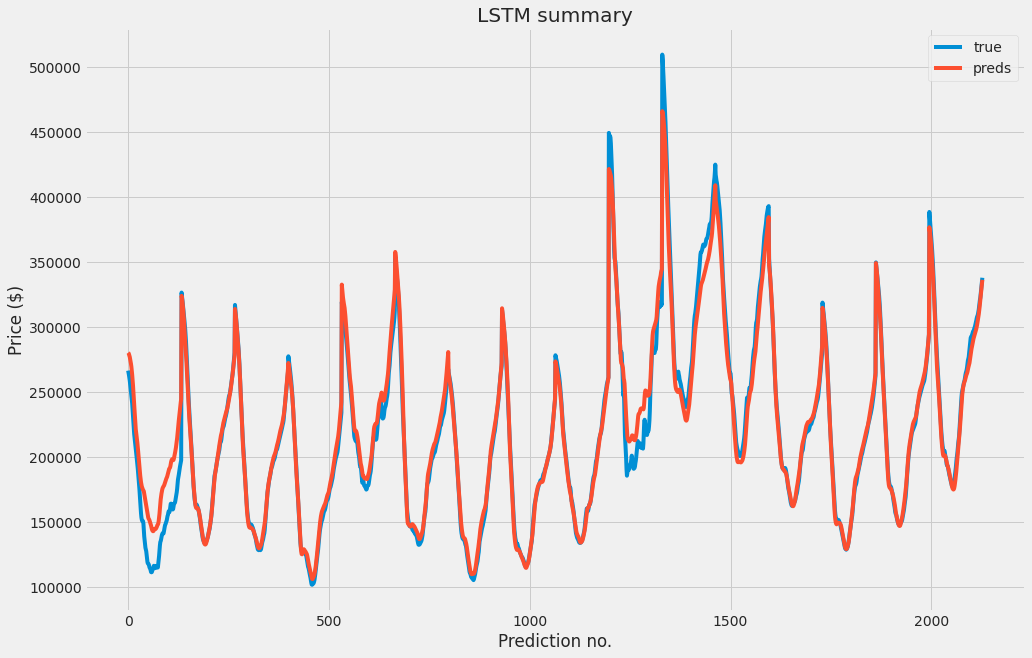

In [22]:
LSTM_val_true, LSTM_val_preds = clean_true_preds(LSTM_model)
LSTM_val_MAPE = mean_absolute_percentage_error(LSTM_val_true, LSTM_val_preds)
quick_plot(LSTM_val_true, LSTM_val_preds, 'LSTM')

results.append({'Model': 'Single_LSTM', 'Val_MAPE': LSTM_val_MAPE})
print(f'Validation Mape {round(LSTM_val_MAPE, 3)}')

In [23]:
pd.DataFrame(results)

,Model,Val_MAPE
0,Single_LSTM,0.035008


## **4.2 Single Layer GRU Model**

In [24]:
from tensorflow.keras.layers import GRU

GRU_model = Sequential()
GRU_model.add(GRU(units=64, activation='relu', return_sequences=False, input_shape = (X_train.shape[1], X_train.shape[2])))
GRU_model.add(Dense(units=1))

summary = GRU_model.summary()

GRU_model.compile(optimizer = 'adam', loss = "mean_squared_error")

filepath = 'drive/MyDrive/DS_Projects/US_housing_time_series/models/GRU_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

history = GRU_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=32, callbacks = [checkpoint])
GRU_model = load_model('drive/MyDrive/DS_Projects/US_housing_time_series/models/GRU_model.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                19200     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.0474
Epoch 1: val_loss improved from inf to 0.00666, saving model to drive/MyDrive/DS_Projects/US_housing_time_series/models/GRU_model.hdf5
250/250 [==============================] - 5s 16ms/step - loss: 0.0474 - val_loss: 0.0067
Epoch 2/25
248/250 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 2: val_loss improved from 0.00666 to 0.00405, saving model to

Validation Mape 0.016


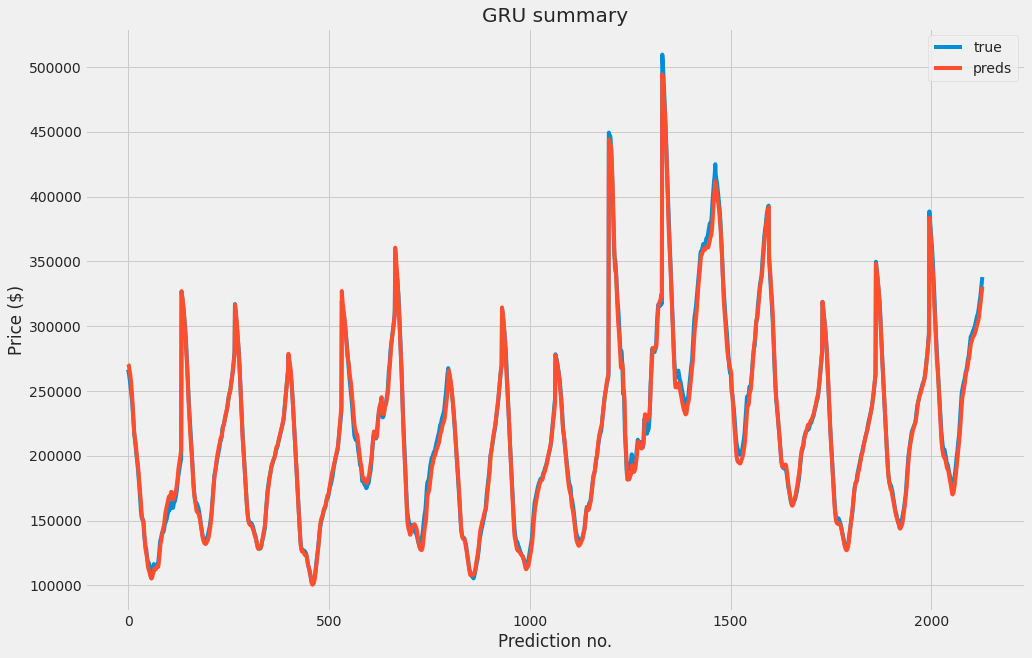

In [25]:
GRU_val_true, GRU_val_preds = clean_true_preds(GRU_model)
GRU_val_MAPE = mean_absolute_percentage_error(GRU_val_true, GRU_val_preds)
quick_plot(GRU_val_true, GRU_val_preds, 'GRU')

results.append({'Model': 'Single_GRU', 'Val_MAPE': GRU_val_MAPE})
print(f'Validation Mape {round(GRU_val_MAPE, 3)}')

In [26]:
pd.DataFrame(results)

,Model,Val_MAPE
0,Single_LSTM,0.035008
1,Single_GRU,0.016181


## **4.3 Deep LSTM Model**

In [27]:
deep_LSTM_model = Sequential()
deep_LSTM_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
deep_LSTM_model.add(Dropout(0.2))
deep_LSTM_model.add(LSTM(units=32, activation='relu', return_sequences=False))
deep_LSTM_model.add(Dropout(0.2))
deep_LSTM_model.add(Dense(units=1))

summary = deep_LSTM_model.summary()

deep_LSTM_model.compile(optimizer = 'adam', loss = "mean_squared_error")

filepath = 'drive/MyDrive/DS_Projects/US_housing_time_series/models/deep_LSTM_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

history = deep_LSTM_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=32, callbacks = [checkpoint])
deep_LSTM_model = load_model('drive/MyDrive/DS_Projects/US_housing_time_series/models/deep_LSTM_model.hdf5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 64)            25344     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37,793
Trainable params: 37,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
249/250 [============================>.

Validation Mape 0.043


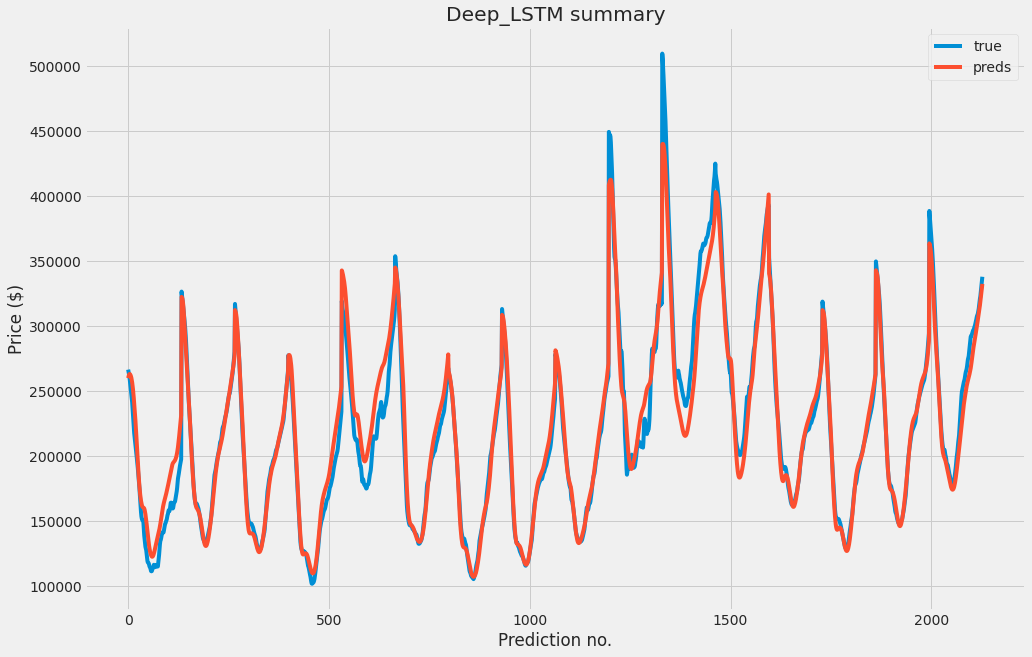

In [28]:
deep_LSTM_val_true, deep_LSTM_val_preds = clean_true_preds(deep_LSTM_model)
deep_LSTM_val_MAPE = mean_absolute_percentage_error(deep_LSTM_val_true, deep_LSTM_val_preds)
quick_plot(deep_LSTM_val_true, deep_LSTM_val_preds, 'Deep_LSTM')

results.append({'Model': 'Deep_LSTM', 'Val_MAPE': deep_LSTM_val_MAPE})
print(f'Validation Mape {round(deep_LSTM_val_MAPE, 3)}')

In [29]:
pd.DataFrame(results)

,Model,Val_MAPE
0,Single_LSTM,0.035008
1,Single_GRU,0.016181
2,Deep_LSTM,0.042730


## **4.4 Deep GRU Model**

In [30]:
deep_GRU_model = Sequential()
deep_GRU_model.add(GRU(units=64, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
deep_GRU_model.add(Dropout(0.2))
deep_GRU_model.add(GRU(units=32, activation='relu', return_sequences=False))
deep_GRU_model.add(Dropout(0.2))
deep_GRU_model.add(Dense(units=1))

summary = deep_GRU_model.summary()

deep_GRU_model.compile(optimizer = 'adam', loss = "mean_squared_error")

filepath = 'drive/MyDrive/DS_Projects/US_housing_time_series/models/deep_GRU_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

history = deep_GRU_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=32, callbacks = [checkpoint])
deep_GRU_model = load_model('drive/MyDrive/DS_Projects/US_housing_time_series/models/deep_GRU_model.hdf5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 24, 64)            19200     
                                                                 
 dropout_2 (Dropout)         (None, 24, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 28,641
Trainable params: 28,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
249/250 [============================>.

Validation Mape 0.035


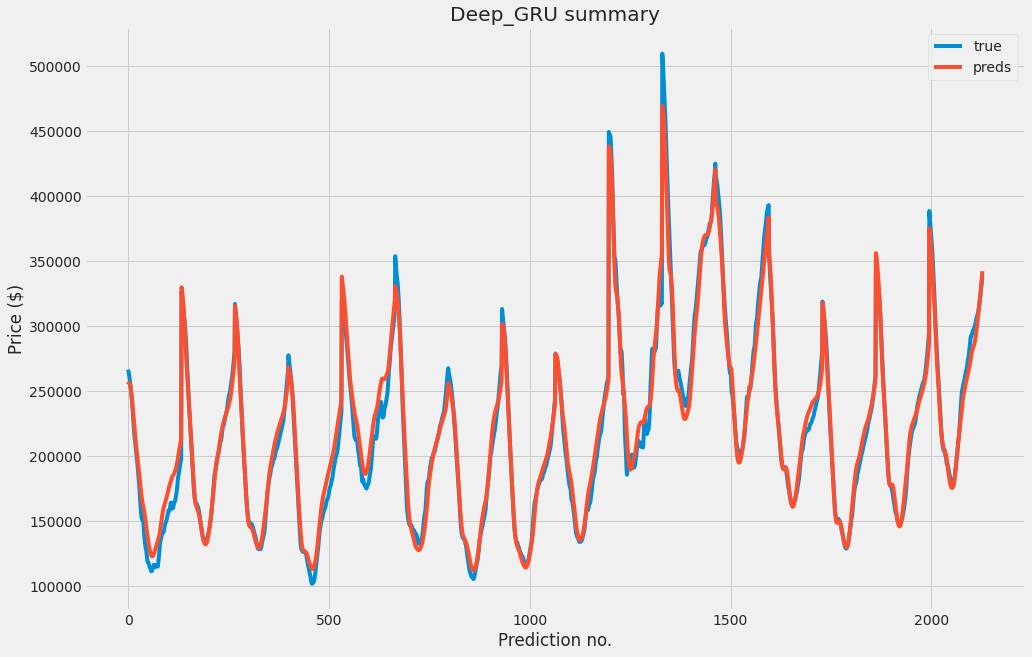

In [31]:
deep_GRU_val_true, deep_GRU_val_preds = clean_true_preds(deep_GRU_model)
deep_GRU_val_MAPE = mean_absolute_percentage_error(deep_GRU_val_true, deep_GRU_val_preds)
quick_plot(deep_GRU_val_true, deep_GRU_val_preds, 'Deep_GRU')

results.append({'Model': 'Deep_GRU', 'Val_MAPE': deep_GRU_val_MAPE})
print(f'Validation Mape {round(deep_GRU_val_MAPE, 3)}')

In [32]:
pd.DataFrame(results)

,Model,Val_MAPE
0,Single_LSTM,0.035008
1,Single_GRU,0.016181
2,Deep_LSTM,0.042730
3,Deep_GRU,0.034718


## **4.5 CNN Model**

In [34]:
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D

CNN_model = Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size = 2, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
CNN_model.add(MaxPooling1D(pool_size = 2))
CNN_model.add(Flatten())
CNN_model.add(Dense(units=200))
CNN_model.add(Dense(units=1))

summary = CNN_model.summary()

CNN_model.compile(optimizer = 'adam', loss = "mean_squared_error")

filepath = 'drive/MyDrive/DS_Projects/US_housing_time_series/models/CNN_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

history = CNN_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25, batch_size=32, callbacks = [checkpoint])
CNN_model = load_model('drive/MyDrive/DS_Projects/US_housing_time_series/models/CNN_model.hdf5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            4416      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               141000    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
________________________________________________

Validation Mape 0.052


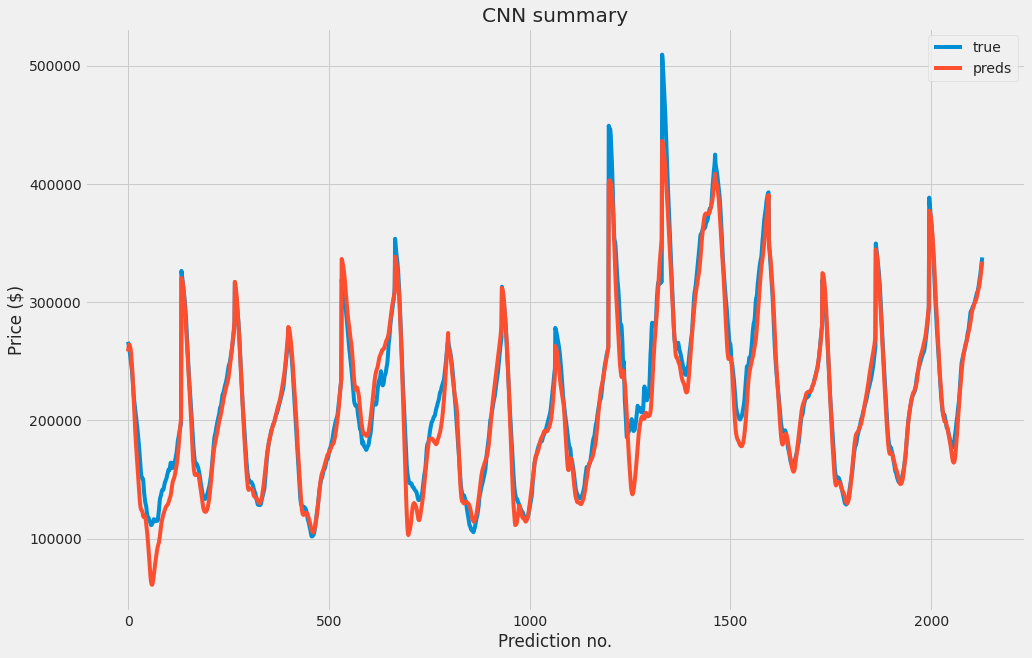

In [35]:
CNN_val_true, CNN_val_preds = clean_true_preds(CNN_model)
CNN_val_MAPE = mean_absolute_percentage_error(CNN_val_true, CNN_val_preds)
quick_plot(CNN_val_true, CNN_val_preds, 'CNN')

results.append({'Model': 'CNN', 'Val_MAPE': CNN_val_MAPE})
print(f'Validation Mape {round(CNN_val_MAPE, 3)}')

In [36]:
pd.DataFrame(results)

,Model,Val_MAPE
0,Single_LSTM,0.035008
1,Single_GRU,0.016181
2,Deep_LSTM,0.042730
3,Deep_GRU,0.034718
4,CNN,0.051782


# **5.0 Evaluation**

## **5.1 Model Comparison**

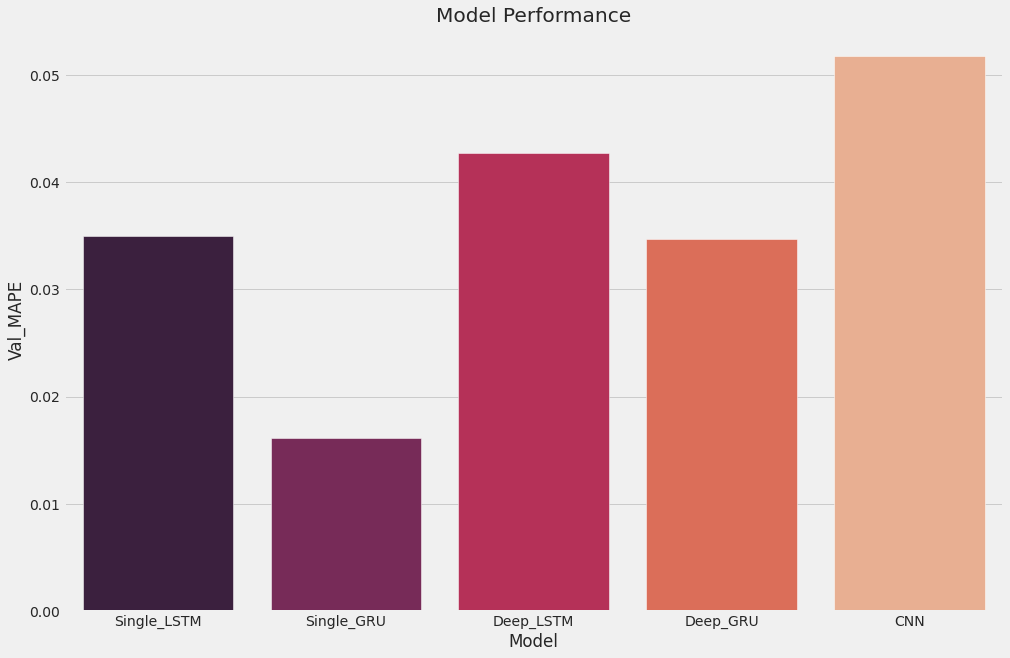

In [46]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(data = pd.DataFrame(results), x = 'Model', y = 'Val_MAPE', palette = 'rocket')
ax.set_title('Model Performance');

## **5.2 Testing our best Model**
With our single layer GRU performing the best on validationa data, we'll now try it on test data.

In [ ]:
model_val_preds_raw = model.predict(X_val)
model_val_preds_copies = np.repeat(model_val_preds_raw, 8, axis = -1)
model_val_preds = scaler.inverse_transform(model_val_preds_copies)[:, 0]
y_val_copies = np.repeat(y_val.reshape(-1,1), 8, axis = -1)
y_val_true = scaler.inverse_transform(y_val_copies)[:, 0]



In [ ]:
GRU_val_true, GRU_val_preds = clean_true_preds(GRU_model)
GRU_val_MAPE = mean_absolute_percentage_error(GRU_val_true, GRU_val_preds)
quick_plot(GRU_val_true, GRU_val_preds, 'GRU')

results.append({'Model': 'Single_GRU', 'Val_MAPE': GRU_val_MAPE})
print(f'Validation Mape {round(GRU_val_MAPE, 3)}')